In [ ]:
"""
Compute Additive bias on DC2 galaxies based on their bulge size, disk size, and B/T ratio.
You need GCRCatalog + DC2 data to do this.
"""

In [2]:
import numpy as np
import galsim
from astropy.table import Table
from os import path
import os
import treecorr
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import GCRCatalogs
import pickle
from scipy import interpolate
import healpy as hp
import seaborn as sns
from scipy.optimize import curve_fit


In [3]:
import GCRCatalogs

In [4]:
scratch = '/global/cscratch1/sd/ztq1996/HSC_maps_correlations/'

In [5]:
def write_table(table,filename):
    if path.isfile(filename):
        os.remove(filename)
    table.write(filename,format = 'fits')

In [6]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [7]:
#gc.list_all_quantities()

In [8]:
#dir(gc)

In [9]:
magrmax = 25.3
PSF_size = 0.305
bulge_min = 0.1
bulge_max = 1.0
disk_min = 0.2
disk_max = 2.0
#total_min = 0.2


data = gc.get_quantities(['ra', 'dec', 'redshift', 'shear_1', 'shear_2','size_true', 'size_bulge_true','size_disk_true', 'bulge_to_total_ratio_i', ], filters=['mag_true_i < {}'.format(magrmax), 'size_bulge_true > {}'.format(bulge_min), 'size_bulge_true < {}'.format(bulge_max), 'size_disk_true > {}'.format(disk_min), 'size_disk_true < {}'.format(disk_max)  ])




In [10]:
print(data['redshift'].shape)

(55974793,)


In [11]:
zmin = [0.0,0.8,1.5]
zmax = [0.8,1.5,9999]

redshift = data['redshift']
redshift_mid = []

for i in range(3):
    mask1 = redshift<zmax[i]
    mask2 = redshift>zmin[i]
    mask = mask1*mask2
    redshift1 = redshift[mask!=0]
    print(np.mean(redshift1),redshift1.shape)

print(redshift.shape)

0.5077668756971612 (24311403,)
1.0792003467554334 (25140569,)
1.853082784633557 (6522821,)
(55974793,)


In [12]:
x = np.load('data/bpd_additive/x.npy')
dg1 = np.load('data/bpd_additive/dg1.npy')
dg2 = np.load('data/bpd_additive/dg2.npy')
pq4nersc = np.load('data/bpd_additive/pq4nersc.npy')
maps = np.load(scratch+'data/size_ratio_generation/comaps.npy')
R2 = np.load('data/bpd_additive/R2.npy')

In [16]:
R2_interpolation = interpolate.NearestNDInterpolator(x, R2)

In [17]:
R2_array = R2_interpolation(dc2_bpd_params)

In [54]:
for key in data.keys():
    data[key] = data[key][R2_array>0.3]

In [13]:
interp_func1_dic = {}
interp_func2_dic = {}

for i in range(11):
#     this_f1 = interpolate.LinearNDInterpolator(x, dg1[i])
#     this_f2 = interpolate.LinearNDInterpolator(x, dg2[i])

    this_f1 = interpolate.NearestNDInterpolator(x, dg1[i])
    this_f2 = interpolate.NearestNDInterpolator(x, dg2[i])
    interp_func1_dic[tuple(pq4nersc[i])] = this_f1
    interp_func2_dic[tuple(pq4nersc[i])] = this_f2

In [14]:
true_shear1 = data['shear_1'].copy() #- np.mean(data['shear_1'])
true_shear2 = data['shear_2'].copy() #- np.mean(data['shear_2'])

In [21]:
dc2_bulge_size[0:20]

array([3.7865162, 4.2170053, 2.6606398, 2.0244248, 1.5764774, 1.4385351,
       1.461726 , 2.7644908, 2.0936346, 4.472486 , 4.29208  , 4.041654 ,
       1.9944458, 3.4485528, 2.9943256, 3.2717826, 1.4438276, 3.9026213,
       3.4713295, 2.7386754], dtype=float32)

In [15]:
#preparation work

reduce_pq = [(4,0),(0,4),(6,0),(4,2),(2,4),(0,6),(3,1),(1,3),(5,1),(3,3),(1,5)]
ra_rad_array = data['ra']/180.0*np.pi
dec_rad_array = np.abs(data['dec']/180.0*np.pi)

NSIDE = 2048
mappixel = hp.pixelfunc.ang2pix(NSIDE, dec_rad_array,ra_rad_array)

dc2_bulge_size = data['size_bulge_true']/0.2
dc2_disk_size = data['size_disk_true']/0.2
dc2_ratio = data['bulge_to_total_ratio_i']

dc2_bpd_params = np.array([dc2_bulge_size,dc2_disk_size,dc2_ratio]).T
dc2_hlr = data["size_true"]

In [ ]:
nob = 11
for i in range(nob):
    print(i)
    this_map = maps[i]
    this_moment = []
    this_pq = reduce_pq[i]
    for j in range(len(mappixel)):
        this_moment.append(this_map[mappixel[j]])
    this_moment = np.array(this_moment)
    
    #this_moment -= np.mean(this_moment)
    
    print(this_pq, np.mean(this_moment))
    #data[this_pq] = this_moment
    this_c1 = interp_func1_dic[this_pq](dc2_bpd_params) * this_moment
    this_c2 = interp_func2_dic[this_pq](dc2_bpd_params) * this_moment
    data['dg1'+str(this_pq)] = this_c1
    data['dg2'+str(this_pq)] = this_c2
    
    del this_moment, this_c1, this_c2

0
(4, 0) 0.0008204938574984074
1
(0, 4) 0.0005399461663706165
2
(6, 0) 0.005977753375483963
3
(4, 2) 0.0004881923955633744
4
(2, 4) 0.0003408569565874523
5


In [26]:
obs_shear1 = data['shear_1'].copy()
obs_shear2 = data['shear_2'].copy()
true_shear1 = data['shear_1'].copy()
true_shear2 = data['shear_2'].copy()
for j in range(nob):
    obs_shear1 += data['dg1'+str(reduce_pq[j])]
    obs_shear2 += data['dg2'+str(reduce_pq[j])]
    
diff_shear1 = obs_shear1-true_shear1
diff_shear2 = obs_shear2-true_shear2

In [35]:
diff_shear1.shape

(7249227,)

In [2]:
def save_tomographic_table(data, n_tomo, tomo_division):
    for i in range(n_tomo):
        if i==0:
            zmin = 0.0
            zmax = tomo_division[i]
        elif i==n_tomo - 1:
            zmin = tomo_division[i - 1]
            zmax = 10.0
        else:
            zmin = tomo_division[i - 1]
            zmax = tomo_division[i]
            
        redshift_mask1 = (data['redshift']<zmax)
        redshift_mask2 = (data['redshift']>zmin)
        redshift_mask = redshift_mask1 * redshift_mask2
        
        dec = data['dec'][redshift_mask!=0]
        ra = data['ra'][redshift_mask!=0]
        
        obs_shear1 = data['shear_1'].copy()[redshift_mask!=0]#  - np.mean(data['shear_1'])
        obs_shear2 = data['shear_2'].copy()[redshift_mask!=0]# - np.mean(data['shear_1'])
        true_shear1 = data['shear_1'].copy()[redshift_mask!=0]#  - np.mean(data['shear_1'])
        true_shear2 = data['shear_2'].copy()[redshift_mask!=0]#  - np.mean(data['shear_1'])
        for j in range(nob):
            obs_shear1 += data['dg1'+str(reduce_pq[j])][redshift_mask!=0]
            obs_shear2 += data['dg2'+str(reduce_pq[j])][redshift_mask!=0]
            
        raw_table = Table([ra,dec,true_shear1,true_shear2], names=('ra', 'dec','shear1','shear2'))
        write_table(raw_table,'data/bpd_tomographic/raw_table_bin'+str(i)+'.fits')

        obs_table = Table([ra,dec,obs_shear1,obs_shear2], names=('ra', 'dec','shear1','shear2'))
        write_table(obs_table,'data/bpd_tomographic/obs_table_bin'+str(i)+'.fits')
        
        diff_table = Table([ra,dec,obs_shear1-true_shear1,obs_shear2-true_shear2], names=('ra', 'dec','shear1','shear2'))
        write_table(diff_table,'data/bpd_tomographic/diff_table_bin'+str(i)+'.fits')
        

In [23]:
data['shear_1'].copy()[redshift_mask!=0].shape

(23074697,)

In [3]:
def process_table(n_tomo, raw = True):
    results = dict()
    if raw:
        

        

        catlist = []


        for i in range(n_tomo):
            catraw = treecorr.Catalog('data/bpd_tomographic/raw_table_bin'+str(i)+'.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', npatch = 10)
            catlist.append(catraw)

        for i in range(n_tomo):
            for j in range(i,n_tomo):

                cat1 = catlist[i]
                cat2 = catlist[j] 
                ggraw = treecorr.GGCorrelation(min_sep=0.1, max_sep=400, nbins=20, sep_units='arcmin',var_method = 'jackknife')

                ggraw.process(cat1, cat2)

                results['r'] = np.exp(ggraw.meanlogr)
                results['xip_raw_'+str(i)+str(j)] = ggraw.xip
                results['xim_raw_'+str(i)+str(j)] = ggraw.xim
                results['sigxip_raw_'+str(i)+str(j)] = np.sqrt(ggraw.varxip)
                results['sigxim_raw_'+str(i)+str(j)] = np.sqrt(ggraw.varxim)
                results['cov_raw_'+str(i)+str(j)] = ggraw.cov
                
        


    else:
        
        catlist = []


        for i in range(n_tomo):
            catobs = treecorr.Catalog('data/bpd_tomographic/obs_table_bin'+str(i)+'.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', npatch = 10)
            catlist.append(catobs)

        for i in range(n_tomo):
            for j in range(i,n_tomo):
                cat1 = catlist[i]
                cat2 = catlist[j] 
                ggobs = treecorr.GGCorrelation(min_sep=0.1, max_sep=400, nbins=20, sep_units='arcmin',var_method = 'jackknife')

                ggobs.process(cat1, cat2)

                results['r'] = np.exp(ggobs.meanlogr)
                results['xip_obs_'+str(i)+str(j)] = ggobs.xip
                results['xim_obs_'+str(i)+str(j)] = ggobs.xim
                results['sigxip_obs_'+str(i)+str(j)] = np.sqrt(ggobs.varxip)
                results['sigxim_obs_'+str(i)+str(j)] = np.sqrt(ggobs.varxim)
                results['cov_obs_'+str(i)+str(j)] = ggobs.cov

    return results
        
        
        
        
        
        

In [4]:
def process_diff(n_tomo):
    results = dict()
    catlist = []
    
    tmp_dir = 'data/tempt_data/'
    cen_file = 'patch_center.fits'
    small_cat = treecorr.Catalog('data/bpd_tomographic/diff_table_bin0.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', npatch = 10, every_nth=100)
    small_cat.write_patch_centers(cen_file)

    for i in range(n_tomo):
        catdiff = treecorr.Catalog('data/bpd_tomographic/diff_table_bin'+str(i)+'.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', 
                                  patch_centers=cen_file, save_patch_dir=tmp_dir)
        catlist.append(catdiff)

    for i in range(n_tomo):
        for j in range(i,n_tomo):
            print(i,j)
            cat1 = catlist[i]
            cat2 = catlist[j] 
            ggdiff = treecorr.GGCorrelation(min_sep=0.1, max_sep=400, nbins=20, sep_units='arcmin',var_method = 'jackknife')

            ggdiff.process(cat1, cat2, low_mem = True)

            results['r'] = np.exp(ggdiff.meanlogr)
            results['xip_diff_'+str(i)+str(j)] = ggdiff.xip
            results['xim_diff_'+str(i)+str(j)] = ggdiff.xim
            results['sigxip_diff_'+str(i)+str(j)] = np.sqrt(ggdiff.varxip)
            results['sigxim_diff_'+str(i)+str(j)] = np.sqrt(ggdiff.varxim)
            results['cov_diff_'+str(i)+str(j)] = ggdiff.cov
            
    return results
            


In [11]:
diff_results =process_diff(n_tomo) 

0 0
0 1
0 2
1 1
1 2
2 2


In [7]:
with open('data/bpd_tomographic/diff_results.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([diff_results], f)

In [6]:
n_tomo = 3
tomo_division = [0.8,1.5]
zmid = [0.50, 1.06, 1.85]

In [60]:

save_tomographic_table(data, n_tomo, tomo_division)



In [13]:
raw_results = process_table(n_tomo)

In [14]:
with open('data/bpd_tomographic/raw_results.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([raw_results], f)

In [15]:
obs_results = process_table(n_tomo,raw = False)

In [16]:
with open('data/bpd_tomographic/obs_results.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([obs_results], f)

In [17]:
with open('data/bpd_tomographic/raw_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    raw_results = pickle.load(f)[0]
with open('data/bpd_tomographic/obs_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    obs_results = pickle.load(f)[0]

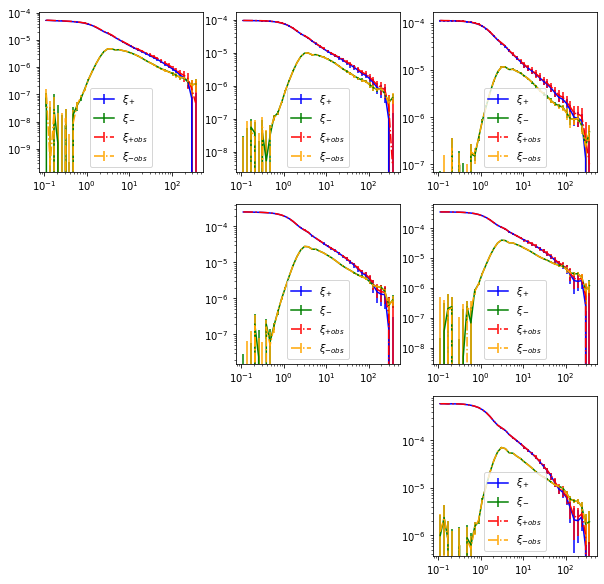

In [6]:
plt.figure(figsize = (10,10))

for i in range(n_tomo):
    for j in range(i,n_tomo):
        #print(i,j)
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]
        
        xip_raw_sig = raw_results['sigxip_raw_'+str(i)+str(j)]
        xim_raw_sig = raw_results['sigxim_raw_'+str(i)+str(j)]
        
        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]
        
        xip_obs_sig = obs_results['sigxip_obs_'+str(i)+str(j)]
        xim_obs_sig = obs_results['sigxim_obs_'+str(i)+str(j)]
        
        plt.errorbar(r,xip_raw,xip_raw_sig, color = 'blue',label = r'$\xi_+$')
        plt.errorbar(r,xim_raw,xim_raw_sig, color = 'green',label = r'$\xi_-$')

        plt.errorbar(r,xip_obs,xip_obs_sig, fmt= '-.', color = 'red',label = r'$\xi_{+ obs}$')
        plt.errorbar(r,xim_obs,xim_obs_sig, fmt= '-.', color = 'orange',label = r'$\xi_{- obs}$')


        plt.xscale('log')
        #plt.yscale('log')
        plt.legend()
        

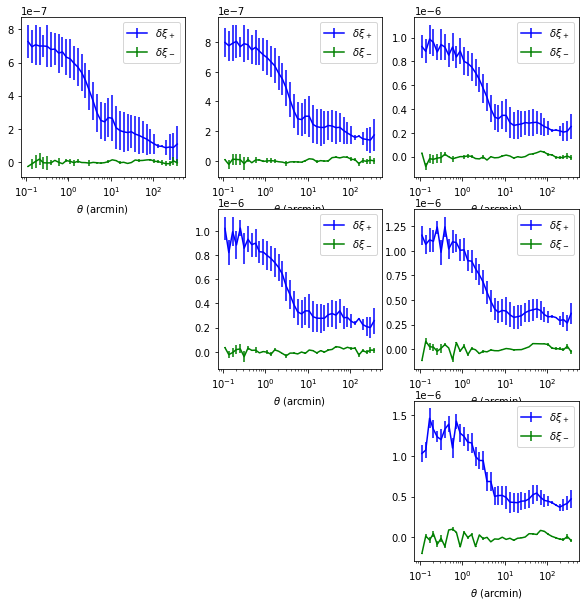

In [7]:
plt.figure(figsize = (10,10))

for i in range(n_tomo):
    for j in range(i,n_tomo):
        #print(i,j)
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        delta_xip = xip_obs - xip_raw
        
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]
        
        
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]
        
        
        
        delta_xim = xim_raw - xim_obs
        
        delta_xip_sig = np.sqrt((raw_results['sigxip_raw_'+str(2)+str(2)] - obs_results['sigxip_obs_'+str(2)+str(2)])**2)
        delta_xim_sig = np.sqrt((raw_results['sigxim_raw_'+str(2)+str(2)] - obs_results['sigxim_obs_'+str(2)+str(2)])**2)

        
        plt.errorbar(r,delta_xip,0.5*delta_xip_sig, color = 'blue',label = r'$\delta \xi_+$')
        plt.errorbar(r,delta_xim,0.5*delta_xim_sig, color = 'green',label = r'$\delta \xi_-$')
        
        plt.xlabel(r'$\theta$ (arcmin)')
    

        plt.xscale('log')
        #plt.yscale('log')
        plt.legend()
        
plt.savefig('figure/delta_xip_xim.png',dpi = 100)
        

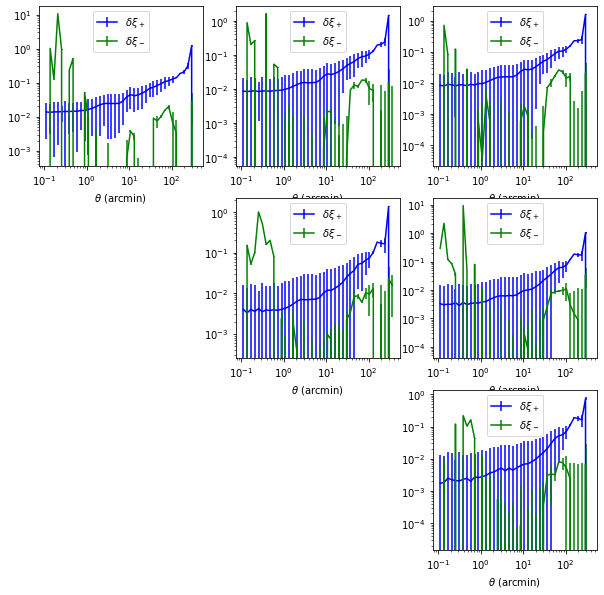

In [24]:
plt.figure(figsize = (10,10))

for i in range(n_tomo):
    for j in range(i,n_tomo):
        #print(i,j)
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]
        
        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]
        
        
        delta_xip = xip_obs - xip_raw
        delta_xim = xim_raw - xim_obs
        
        delta_xip_sig = np.sqrt((raw_results['sigxip_raw_'+str(2)+str(2)] - obs_results['sigxip_obs_'+str(2)+str(2)])**2)
        delta_xim_sig = np.sqrt((raw_results['sigxim_raw_'+str(2)+str(2)] - obs_results['sigxim_obs_'+str(2)+str(2)])**2)

        
        plt.errorbar(r,delta_xip/xip_raw,0.5*delta_xip_sig/raw_results['sigxip_raw_'+str(2)+str(2)], color = 'blue',label = r'$\delta \xi_+$')
        plt.errorbar(r,delta_xim/xim_raw,0.5*delta_xim_sig/raw_results['sigxip_raw_'+str(2)+str(2)], color = 'green',label = r'$\delta \xi_-$')
        
        plt.xlabel(r'$\theta$ (arcmin)')
    

        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        
plt.savefig('figure/delta_xip_xim_ratio.png',dpi = 100)
        

In [26]:
def model(x, amp, scale):
    return np.maximum(amp*np.exp(-scale*x),amp*np.exp(-scale*9))

def model1(x,amp, scale):
    return amp*np.exp(-scale*x)
    
def model2(x, amp):
    return np.maximum(amp*np.exp(-0.15*x),amp*np.exp(-0.15*9))

def model3(x,amp,scale,level):
    return amp*np.exp(-scale*x)

def model4(x, amp,scale, level,b):
    return amp*np.exp(-scale*x)+level*np.power(x,-b)


def model5(x,amp,  level):
    return amp * np.power(x, -0.0085) * ((-np.arctan(x - 2.6 ))/np.pi + 1/2 )+level*np.power(x, -0.05)


def model6(x,amp, b):
    return amp * np.power(x, -b)



In [11]:
popt, pcov = curve_fit(model,r,delta_xip)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [44]:
x_fit = np.arange(0.1,400,0.1)
y_fit = model(x_fit,popt[0], popt[1])

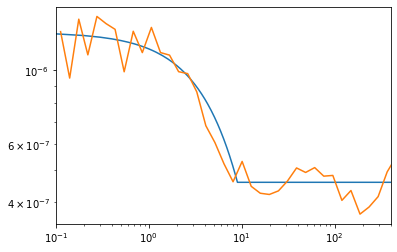

In [45]:
plt.plot(x_fit,y_fit)
plt.plot(r,delta_xip)
plt.xlim([0.1,400])
plt.xscale('log')
plt.yscale('log')

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp


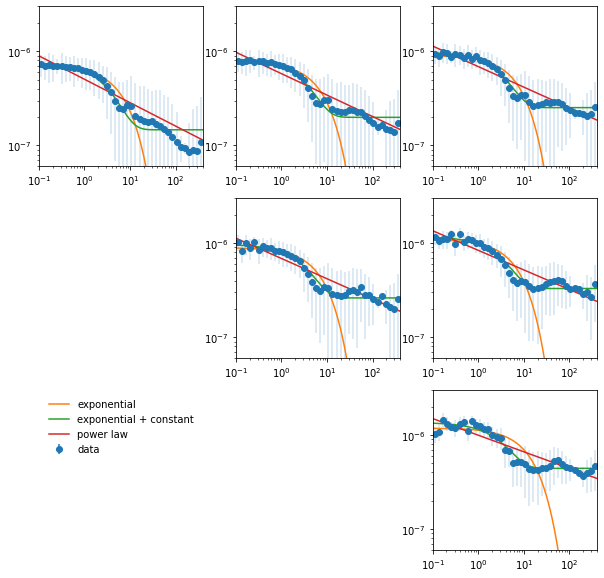

In [33]:
plt.figure(figsize = (10,10))
epsilon = 0.00001


for i in range(n_tomo):
    for j in range(i,n_tomo):
        
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]

        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]


        delta_xip = np.abs(xip_raw - xip_obs)
        delta_xim = np.abs(xim_raw - xim_obs)
        
        delta_xip_sig = np.sqrt((raw_results['sigxip_raw_'+str(2)+str(2)] - obs_results['sigxip_obs_'+str(2)+str(2)])**2)
        
        
        #print(delta_xip_sig.shape, delta_xip.shape)
        plt.errorbar(r, delta_xip, delta_xip_sig, fmt = 'o', elinewidth = 0.3, label = r'data')
        
        
        x_fit = np.arange(0.1,400,0.1)
        
        
        popt1, _ = curve_fit(model1,r,delta_xip)
        y_fit1 = model1(x_fit,popt1[0], popt1[1])
        plt.plot(x_fit,y_fit1, label = r'exponential')
        
#         popt3, _ = curve_fit(model3,r,delta_xip)
#         y_fit3 = model3(x_fit,popt3[0], popt3[1], popt3[2])
#         plt.plot(x_fit,y_fit3, label = r'exponential + constant')
        
        popt4, _ = curve_fit(model4,r,delta_xip, bounds=((-np.inf,0.27,-np.inf,0.0), (np.inf,0.27+epsilon,np.inf,0.0+epsilon)))
        y_fit4 = model4(x_fit,popt4[0], popt4[1], popt4[2],popt4[3])
        plt.plot(x_fit,y_fit4, label = r'exponential + constant')

#         popt5, _ = curve_fit(model5,r,delta_xip)
#         y_fit5 = model5(x_fit,popt5[0], popt5[1])
#         plt.plot(x_fit,y_fit5, label = r'power1 * arctan + power2')
        
        popt6, _ = curve_fit(model6,r,delta_xip)
        y_fit6 = model6(x_fit,popt6[0],popt6[1])
        plt.plot(x_fit, y_fit6, label=r'power law')
        
        plt.ylim([6e-8, 3e-6])
        plt.xlim([0.1,400])
        plt.xscale('log')
        plt.yscale('log')

plt.subplot(3,3,7)
plt.errorbar([],[],[],fmt = 'o',label = r'data')
plt.plot([0],[0],label = r'exponential')
plt.plot([0],[0],label = r'exponential + constant')
# plt.plot([0],[0],label = r'exponential + constant*power')
# plt.plot([0],[0],label = r'power1 * arctan + power2')

plt.plot([0],[0],label = r'power law')

plt.legend(frameon = False)     
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
        
        
plt.savefig('figure/delta_xip_fit.png',dpi = 100)

<ErrorbarContainer object of 3 artists>

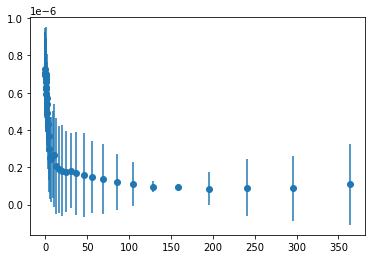

In [23]:
plt.errorbar(r, delta_xip, delta_xip_sig, fmt = 'o',  label = r'data')


In [28]:
print(popt4)

[7.78955710e-07 2.70001615e-01 5.35635075e-07 5.00002809e-02]


[5.99319026e-07 2.14614799e-01 1.34034218e-07 9.96058361e-06]
[6.35948616e-07 2.51257237e-01 1.94819727e-07 9.95533101e-06]
[7.29804304e-07 2.69881334e-01 2.52055645e-07 9.82246362e-06]
[7.19805498e-07 3.05517071e-01 2.68903288e-07 9.92552305e-06]
[8.62290611e-07 3.13272589e-01 3.39859606e-07 9.99999985e-06]
[9.10723564e-07 2.45570891e-01 4.35007686e-07 4.97837665e-06]


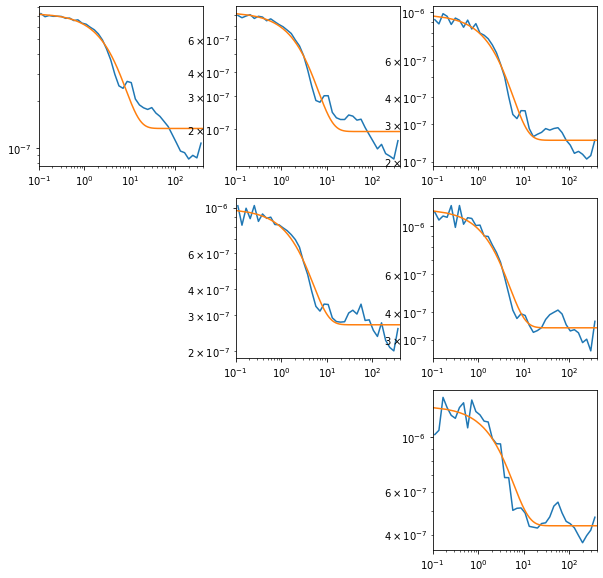

In [19]:
plt.figure(figsize = (10,10))

z1z2 = []
amp = []
level = []



for i in range(n_tomo):
    for j in range(i,n_tomo):
        
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        r = raw_results['r']
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xim_raw = raw_results['xim_raw_'+str(i)+str(j)]

        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        xim_obs = obs_results['xim_obs_'+str(i)+str(j)]


        delta_xip = np.abs(xip_raw - xip_obs)
        delta_xim = np.abs(xim_raw - xim_obs)
        
        popt, _ = curve_fit(model4,r,delta_xip,bounds=((-np.inf,-np.inf,-np.inf,0.0), (np.inf,np.inf,np.inf,0.0+epsilon)))
        #popt, _ = curve_fit(model1,r,delta_xip)

        z1z2.append(zmid[i]+zmid[j])
        amp.append(popt[0])
        level.append(popt[1])
        print(popt)
        x_fit = np.arange(0.1,400,0.1)
        #y_fit = model1(x_fit,popt[0], popt[1])

        y_fit = model4(x_fit,popt[0], popt[1],popt[2], popt[3])
        plt.plot(r,delta_xip, label = r'data')
        plt.plot(x_fit,y_fit, label = r'fit')
        plt.xlim([0.1,400])
        #plt.ylim([1e-9, 3e-6])
        plt.xscale('log')
        plt.yscale('log')

plt.savefig('figure/delta_xip_fit.png',dpi = 100)

In [20]:
poly1 = np.polyfit(z1z2, amp, 1)
print(poly1)
poly2 = np.polyfit(z1z2, level, 1)
print(poly2)

[1.25446537e-07 4.57800142e-07]
[0.01546336 0.23153227]


In [24]:
zfit = np.arange(0,4.0,0.1)
ampfit = poly1[0]*zfit+poly1[1]
levelfit = poly2[0]*zfit + poly2[1]

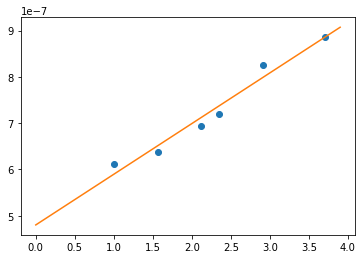

In [25]:
plt.plot(z1z2, amp,'o')
plt.plot(zfit, ampfit)

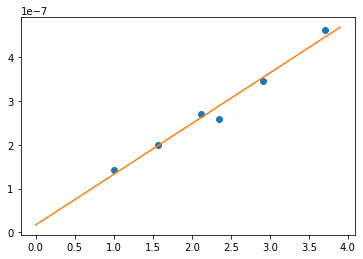

In [26]:
plt.plot(z1z2, level,'o')
plt.plot(zfit, levelfit)

In [27]:
print(poly1)
print(poly2)

[1.09478058e-07 4.80180446e-07]
[1.15965251e-07 1.69322237e-08]


In [4]:
def process_cross(n_tomo):
    results = dict()
    gcatlist = []
    ccatlist = []
    
    tmp_dir = 'data/tempt_data/'
    cen_file = 'patch_center.fits'
    small_cat = treecorr.Catalog('data/bpd_tomographic/diff_table_bin0.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', npatch = 10, every_nth=100)
    small_cat.write_patch_centers(cen_file)
    del small_cat

    for i in range(n_tomo):
        catdiff = treecorr.Catalog('data/bpd_tomographic/diff_table_bin'+str(i)+'.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', 
                                   patch_centers=cen_file, save_patch_dir=tmp_dir)
        ccatlist.append(catdiff)
    for i in range(n_tomo):
        catraw = treecorr.Catalog('data/bpd_tomographic/raw_table_bin'+str(i)+'.fits', ra_col='ra', dec_col='dec', ra_units='deg', dec_units='deg', g1_col='shear1',g2_col= 'shear2', 
                                 patch_centers=cen_file, save_patch_dir=tmp_dir)
        gcatlist.append(catraw)

    for i in range(n_tomo):
        for j in range(i,n_tomo):
            print(i,j)
            cat1 = gcatlist[i]
            cat2 = ccatlist[j] 
            ggdiff = treecorr.GGCorrelation(min_sep=0.1, max_sep=400, nbins=20, sep_units='arcmin',var_method = 'jackknife')

            ggdiff.process(cat1, cat2,low_mem=True)

            results['r'] = np.exp(ggdiff.meanlogr)
            results['xip_diff_'+str(i)+str(j)] = ggdiff.xip
            results['xim_diff_'+str(i)+str(j)] = ggdiff.xim
            results['sigxip_diff_'+str(i)+str(j)] = np.sqrt(ggdiff.varxip)
            results['sigxim_diff_'+str(i)+str(j)] = np.sqrt(ggdiff.varxim)
            results['cov_diff_'+str(i)+str(j)] = ggdiff.cov
            
            if i!=j:
                cat1 = gcatlist[j]
                cat2 = ccatlist[i] 
                ggdiff = treecorr.GGCorrelation(min_sep=0.1, max_sep=400, nbins=20, sep_units='arcmin',var_method = 'jackknife')

                ggdiff.process(cat1, cat2, low_mem=True)

                results['r'] = np.exp(ggdiff.meanlogr)
                results['xip_diff_'+str(j)+str(i)] = ggdiff.xip
                results['xim_diff_'+str(j)+str(i)] = ggdiff.xim
                results['sigxip_diff_'+str(j)+str(i)] = np.sqrt(ggdiff.varxip)
                results['sigxim_diff_'+str(j)+str(i)] = np.sqrt(ggdiff.varxim)
                results['cov_diff_'+str(j)+str(i)] = ggdiff.cov
            
    return results
            


In [15]:
with open('data/bpd_tomographic/diff_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    diff_results = pickle.load(f)[0]

In [5]:
n_tomo = 3
cross_results = process_cross(n_tomo)

0 0
0 1
0 2
1 1
1 2
2 2


In [6]:
with open('data/bpd_tomographic/cross_results.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([cross_results], f)

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

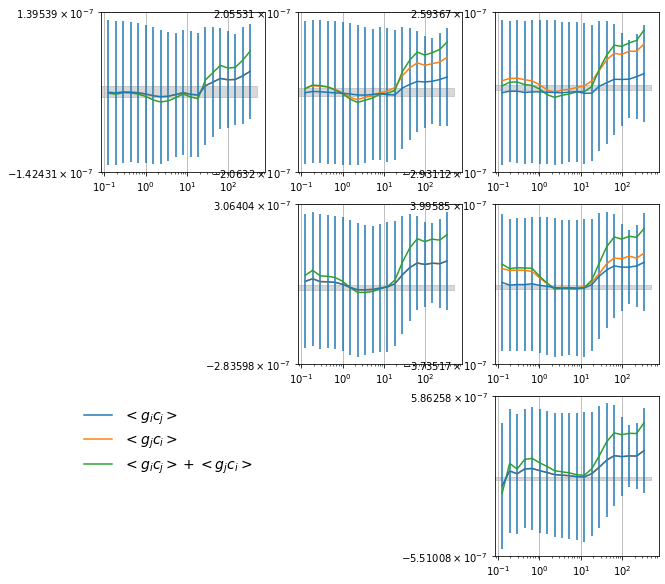

In [20]:
plt.figure(figsize = (10,10))


for i in range(n_tomo):
    for j in range(i,n_tomo):
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)
        ax = plt.gca()
        
        r = cross_results['r']
        xip_ij = cross_results['xip_diff_'+str(i)+str(j)]
        #xip_ij_sig = cross_results['sigxip_diff_'+str(i)+str(j)]
        xip_ij_sig = np.sqrt(np.diag(cross_results['cov_diff_'+str(i)+str(j)][:20]))

        xip_ji = cross_results['xip_diff_'+str(j)+str(i)]
        xip_ji_sig = np.sqrt(np.diag(cross_results['cov_diff_'+str(j)+str(i)][:20]))


        xip_tot = xip_ij + xip_ji 
        xip_sig_tot = xip_ij_sig + xip_ji_sig
        
     
        #print(delta_xip_sig.shape, delta_xip.shape)
        plt.errorbar(r, xip_ij,xip_sig_tot , label = r'data')
        
        plt.plot(r, xip_ji,   label = r'data')
        
        plt.plot(r, xip_tot,   label = r'data')
        #plt.plot(r, delta_xip)

        

        plt.xscale('log')
        plt.yscale('symlog', linscale = 1e-8)
        ax.fill_between(list(range(0,500)), -1e-8, 1e-8, color = 'grey', alpha = 0.3)
        plt.grid()

plt.subplot(3,3,7)
plt.plot([0],[0],label = r'$<g_i c_j>$')
plt.plot([0],[0],label = r'$<g_j c_i>$')
# plt.plot([0],[0],label = r'exponential + constant*power')
# plt.plot([0],[0],label = r'power1 * arctan + power2')

plt.plot([0],[0],label = r'$<g_i c_j> +<g_j c_i> $')

plt.legend(frameon = False, fontsize = 14)     
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')

        
#plt.savefig('figure/delta_xip_fit.png',dpi = 100)

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

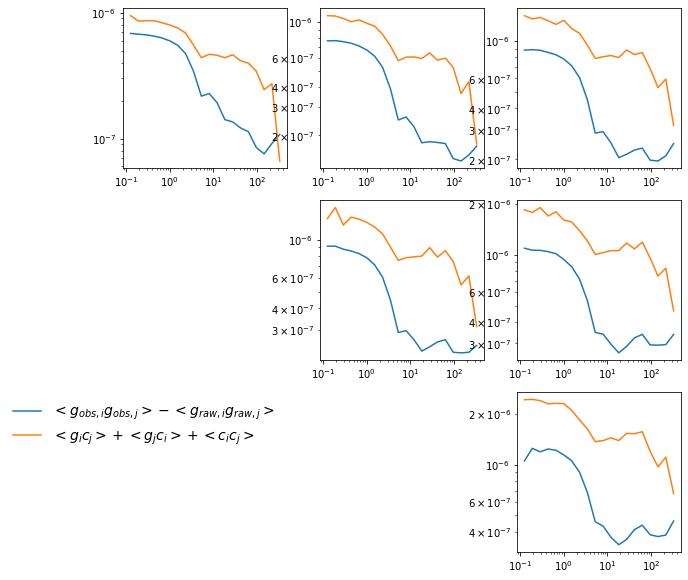

In [18]:
plt.figure(figsize = (10,10))


for i in range(n_tomo):
    for j in range(i,n_tomo):
        plt.subplot(n_tomo,n_tomo,n_tomo*i+j+1)

        
        r = cross_results['r']
        xip_ij = cross_results['xip_diff_'+str(i)+str(j)]

        xip_ji = cross_results['xip_diff_'+str(j)+str(i)]
        dxi = diff_results['xip_diff_'+str(i)+str(j)]
        xip_tot = xip_ij + xip_ji + dxi
        
        xip_raw = raw_results['xip_raw_'+str(i)+str(j)]
        xip_obs = obs_results['xip_obs_'+str(i)+str(j)]
        delta_xip = xip_obs - xip_raw
        
     
        #print(delta_xip_sig.shape, delta_xip.shape)
#         plt.plot(r, xip_ij,  label = r'data')
        
#         plt.plot(r, xip_ji,   label = r'data')
        
        plt.plot(r, xip_tot,   label = r'data')
        plt.plot(r, delta_xip)

        

        plt.xscale('log')
        plt.yscale('log')

plt.subplot(3,3,7)
plt.plot([0],[0],label = r'$<g_{obs,i} g_{obs,j}> - <g_{raw,i} g_{raw,j}>$')
#plt.plot([0],[0],label = r'$<g_j c_i>$')
# plt.plot([0],[0],label = r'exponential + constant*power')
# plt.plot([0],[0],label = r'power1 * arctan + power2')

plt.plot([0],[0],label = r'$<g_i c_j> +<g_j c_i> + <c_i c_j> $')

plt.legend(frameon = False, fontsize = 14)     
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')

        
#plt.savefig('figure/delta_xip_fit.png',dpi = 100)